# Exploring a Nowcast Time Series from ERDDAP

This notebook contains discussion and examples of accessing a time series of
results from the Salish Sea NEMO Nowcast system from the ERDDAP server.
The time series of interest span several days of nowcast runs,
so ERDDAP provides a more convenient way of accessing the results than building
the time series by loading several single day nowcast results file.
We'll use the [xarray](http://xarray.pydata.org/) to demonstrate it powerful
time period selection,
and built-in plotting features that facilitate quick dataset visualization.
Topics include:

* Opening ERDDAP datasets with `xarray`
* Examining dataset and variable metadata
* Creating rudimentary plots of dataset variable for quick visualization
* Selecting single point values of variables from datasets by index and by value
* Selecting time series slices of variables from datasets by date/time ranges

For an introduction to accessing nowcast results datasets from our ERDDAP server,
please see [Exploring netCDF Datasets from ERDDAP.ipynb](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Datasets%20from%20ERDDAP.ipynb).

For an introduction to the xarray package,
please see [Exploring netCDF Datasets Using xarray.ipynb](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Datasets%20Using%20xarray.ipynb).

This notebook assumes that you are working in Python 3.
If you don't have a Python 3 environment set up,
please see our
[Anaconda Python Distribution](http://salishsea-meopar-docs.readthedocs.org/en/latest/work_env/anaconda_python.html)
docs for instructions on how to set one up.

`xarray` and some of the packages that it depends on are not included in the default Anaconda
collection of packages,
so you may need to installed them explicitly:
```
$ conda install xarray netCDF4 bottleneck
```

[`bottleneck`](https://github.com/kwgoodman/bottleneck)
is a package that speeds up NaN-skipping and rolling window aggregations.

If you are using a version of Python earlier than 3.5
(check with the command `python --version`),
you should also install [`cyordereddict`](https://github.com/shoyer/cyordereddict)
to speed internal operations with xarray data structures.
It is not required for Python ≥3.5 because `collections.OrderedDict` has been rewritten
in C,
making it even faster than `cyordereddict`.

As always, we'll start with our imports, and activation of the Matplotlib `inline` backend so that our plots will appear below the cells that create them.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import (
    geo_tools,
    viz_tools,
    wind_tools,
)

In [2]:
%matplotlib inline

First we're going to take a quick look at the Salish Sea NEMO domain
by looking at the metadata in the dataset that contains the mapping of
of the domain's `(x, y)` grid points to longitudes and latitudes.
That dataset also contains the ocean depth at each of those grid points
so we can do a quick colour mesh plot of the model bathymetry too.

The list of datasets available from the Salish Sea NEMO model ERDDAP server
is at https://salishsea.eos.ubc.ca/erddap/info/.
From that list we choose the model grid geo-location and bathymetry dataset
which has the dataset id `ubcSSnBathymetry2V1`.

You can follow the `data` link for that dataset on the `info` page to see more
details about the dataset at https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1.html
but we want to work with the dataset in code,
so we're user `xarray.open_dataset()` to access the dataset.
Note that the URL ends with the dataset id but there is no `.html` or `.nc` extension.

In [3]:
grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1')

Opening the dataset is quick because all that is retrived from the server is the dataset
metadata.
We can examine the metadata by printing the variable `grid` variable that we assigned
the result of `xarray.open_dataset()` to:

In [4]:
print(grid)

<xarray.Dataset>
Dimensions:     (gridX: 398, gridY: 898)
Coordinates:
  * gridY       (gridY) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * gridX       (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    longitude   (gridY, gridX) float32 ...
    latitude    (gridY, gridX) float32 ...
    bathymetry  (gridY, gridX) float64 ...
Attributes:
    acknowledgement: MEOPAR, ONC, Compute Canada
    cdm_data_type: Grid
    comment: Bathymetry, Latitudes and Longitudes
    Conventions: CF-1.6, COARDS, ACDD-1.3
    coverage_content_type: modelResult
    creator_email: sallen@eos.ubc.ca
    creator_name: Salish Sea MEOPAR Project Contributors
    creator_url: https://salishsea-meopar-docs.readthedocs.org/
    drawLandMask: over
    history: [2016-02-05 16:35:19] Created dataset.
[2016-03-02 18:08:56] Changed all variables to zlib=True.
[2016-03-02 18:08:56] Added least_significant_digit=1 and fill_value=0 to bathymetry variable.
[2016-03-03 12:28:37

The [Exploring netCDF Datasets Using xarray.ipynb](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Datasets%20Using%20xarray.ipynb)
notebook has details about the types of metadata and how to access individual elements of it.

For now we're going to use the plotting interface that is built into `xarray.Dataset` objects
to take a look at the domain.

The `grid.bathymetry.plot()` would produce a plot all by itself.
The extra statements around it are to make the plot larger,
present it with the correct aspect ratio,
and add a grid.

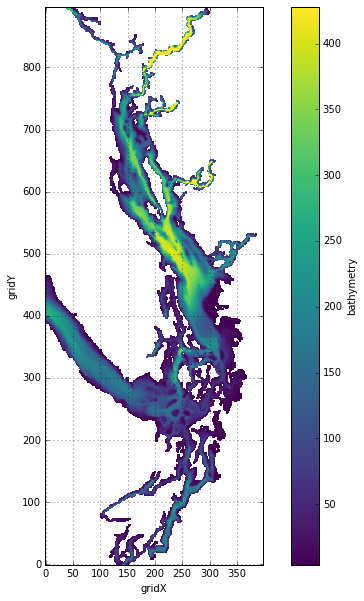

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
viz_tools.set_aspect(ax)
grid.bathymetry.plot(ax=ax)
ax.grid(axis='both')

Now let's take a look at a sea surface temperature time series
at the `(gridY, gridX) = (500, 250)` point in the middle of
the Strait of Georgia.
Having decided on the grid point that we want to look at,
let's store it in a variable:

In [6]:
nemo_ji = (500, 250)

The water temperature calculated by the model is stored in the `ubcSSn3DTracerFields1hV1` dataset:

In [7]:
tracers = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DTracerFields1hV1')
print(tracers)

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 14904)
Coordinates:
  * time         (time) datetime64[ns] 2014-09-24T00:30:00 ...
  * depth        (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
  * gridY        (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    salinity     (time, depth, gridY, gridX) float64 ...
    temperature  (time, depth, gridY, gridX) float64 ...
Attributes:
    acknowledgement: MEOPAR, ONC, Compute Canada
    cdm_data_type: Grid
    Conventions: CF-1.6, COARDS, ACDD-1.3
    coverage_content_type: modelResult
    creator_email: sallen@eos.ubc.ca
    creator_name: Salish Sea MEOPAR Project Contributors
    creator_url: https://salishsea-meopar-docs.readthedocs.org/
    drawLandMask: over
    file_name: SalishSea_1h_20160605_20160605_grid_T.nc
    history: Sun Jun  5 16:21:54 2016: ncks -4 -L4 -O SalishSea_1h_201606

Let's use the Python `slice()` built-in to define the time period for our time series.

Then we use the `.sel()` and `.isel()` methods on our dataset variable to a time series
at:
* the depth level nearest the surface (0.5 m)
* the `(gridY, gridX)` point we chose above
* the time period we're interested in

`.sel()` is used to select by variable values.
`.isel()` is used to select by data array indices.

In [8]:
time_slice = slice('2016-04-12 12:00:00', '2016-04-15 12:00:00')

sst_ts = (
    tracers.temperature
    .sel(depth=0.5, method='nearest')
    .isel(gridY=nemo_ji[0], gridX=nemo_ji[1])
    .sel(time=time_slice)
)

In [9]:
print(sst_ts)

<xarray.DataArray 'temperature' (time: 72)>
array([ 10.32647896,  10.31182003,  10.29314327,  10.27291679,
        10.24502754,  10.21254921,  10.20513344,  10.22968483,
        10.25965405,  10.28726673,  10.3109436 ,  10.31446552,
        10.30096149,  10.27960873,  10.25584126,  10.23131561,
        10.21692562,  10.21260738,  10.20860863,  10.19730568,
        10.18265343,  10.16810799,  10.15409946,  10.14090729,
        10.12986755,  10.12731171,  10.12561607,  10.11983299,
        10.11456394,  10.10525227,  10.10963058,  10.12554932,
        10.14661407,  10.16364193,  10.1686697 ,  10.17202663,
        10.17286396,  10.16785336,  10.15109825,  10.11667442,
        10.07461452,  10.04056072,  10.01904583,  10.00424671,
         9.99383259,   9.99546432,   9.99157524,   9.9837141 ,
         9.97451019,   9.9607048 ,   9.94492912,   9.93665409,
         9.9361124 ,   9.94130993,   9.96282959,  10.00479698,
        10.04234219,  10.07499599,  10.10446739,  10.12510204,
        10.

Again,
we'll use the built-in `xarray.Dataset.plot()` method to quickly visualize
out temperature time series,
with a couple of matplotlib lines added to change the size of the plot
and add grid lines to the x-axis.

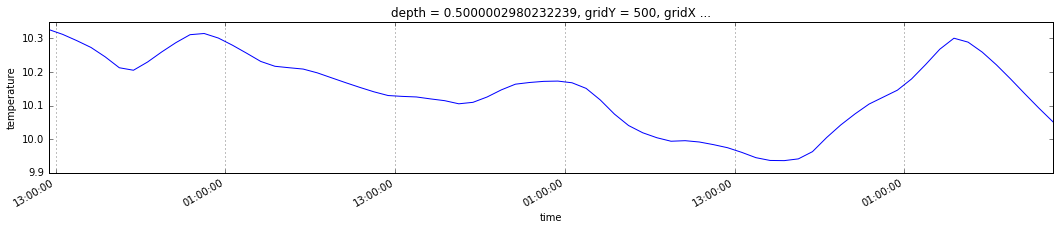

In [10]:
fig, ax = plt.subplots(figsize=(18, 3))
sst_ts.plot(ax=ax)
ax.grid(axis='x')

Now we'll get the longitude and latitude of our point of interest from the `grid` dataset:

In [11]:
nemo_lon = grid.longitude.isel(gridY=nemo_ji[0], gridX=nemo_ji[1])
nemo_lat = grid.latitude.isel(gridY=nemo_ji[0], gridX=nemo_ji[1])
nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
print(nemo_lon_lat)

(-123.7665023803711, 49.30873107910156)


Let's compare the sea surface temperature to the wind speed that was used to force
the model during the same time period.

The atmospheric forcing that is used for the nowcast system is
a processed model product from the Environment and Climate Change Canada
High Resolution Deterministic Prediction System (HDRPS) GEM 2.5 km resolution model.
As was the case for the NEMO model results,
the grid parameters for the atmospheric forcing
(different from those for the NEMO model)
are stored in a separate dataset from the model product variable values.

We start by opening and examining the atmospheric forcing grid dataset:

In [12]:
atmos_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
print(atmos_grid)

<xarray.Dataset>
Dimensions:    (gridX: 256, gridY: 266)
Coordinates:
  * gridY      (gridY) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * gridX      (gridX) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
Data variables:
    longitude  (gridY, gridX) float32 ...
    latitude   (gridY, gridX) float32 ...
Attributes:
    acknowledgement: Environment Canada, MEOPAR, ONC, Compute Canada
    cdm_data_type: Grid
    Conventions: CF-1.6, COARDS, ACDD-1.3
    coverage_content_type: modelResult
    creator_email: sallen@eos.ubc.ca
    creator_name: Salish Sea MEOPAR Project Contributors
    creator_url: https://salishsea-meopar-docs.readthedocs.org/
    drawLandMask: over
    GRIB2_grid_template: 20
    history: Mon Mar  7 10:07:34 2016: ncks -4 -L4 -O /results/forcing/atmospheric/GEM2.5/operational/ops_y2016m03d07.nc /results/forcing/atmospheric/GEM2.5/operational/ops_y2016m03d07.nc
    created by wgrib2
2016-06-06T18:32:50Z (local files)
2016-06-06T18:32:50Z https://salishsea

Now we'll use a library function
[salishsea_tools.geo_tools.find_closest_model_point()](http://salishsea-meopar-tools.readthedocs.io/en/latest/SalishSeaTools/api.html#salishsea_tools.geo_tools.find_closest_model_point)
to find the indices of the atmospheric forcing grid point that is closest to
our the longitude and latitude of our NEMO grid point of interest.
Note that the atmospheric grid uses a longitude range of 0° to 360° east
in contrast to the NEMO range of -180° to 180° east,
so we subtract 360° from the atmospheric longitudes to bring them to the same basis.

In [13]:
atmos_ji = geo_tools.find_closest_model_point(
    nemo_lon_lat[0], nemo_lon_lat[1],
    atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
    grid = "GEM2.5")
print(atmos_ji)

(148, 139)


Confirming that our atmospheric forcing and NEMO model grid points are
indeed close:

In [14]:
atmos_lon_lat = (
    np.asscalar(atmos_grid.longitude.isel(gridY=atmos_ji[1], gridX=atmos_ji[0]) - 360),
    np.asscalar(atmos_grid.latitude.isel(gridY=atmos_ji[0], gridX=atmos_ji[1])))
print('NEMO:', nemo_lon_lat)
print('GEM2.5:', atmos_lon_lat)

NEMO: (-123.7665023803711, 49.30873107910156)
GEM2.5: (-123.42138671875, 49.31491470336914)


Opening and examing the GEM2.5 model variables dataset:

In [15]:
atmos = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
print(atmos)

<xarray.Dataset>
Dimensions:    (gridX: 256, gridY: 266, time: 15192)
Coordinates:
  * time       (time) datetime64[ns] 2014-09-12 2014-09-12T01:00:00 ...
  * gridY      (gridY) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * gridX      (gridX) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
Data variables:
    atmpres    (time, gridY, gridX) float64 ...
    precip     (time, gridY, gridX) float64 ...
    qair       (time, gridY, gridX) float64 ...
    solar      (time, gridY, gridX) float64 ...
    tair       (time, gridY, gridX) float64 ...
    therm_rad  (time, gridY, gridX) float64 ...
    u_wind     (time, gridY, gridX) float64 ...
    v_wind     (time, gridY, gridX) float64 ...
Attributes:
    acknowledgement: MEOPAR, ONC, Compute Canada, Environment Canada
    cdm_data_type: Grid
    Conventions: CF-1.6, COARDS, ACDD-1.3
    coverage_content_type: modelResult
    creator_email: sallen@eos.ubc.ca
    creator_name: Salish Sea MEOPAR Project Contributors
    creator_u

We use similar selection method to those we used to get our sea surface temperature
time series to get time series of the `u` and `v` direction wind components
and the wind speed by calculating their vector magnitude point-by-point:

In [16]:
u_wind_ts = (
    atmos.u_wind
    .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
    .sel(time=time_slice)
)
print(u_wind_ts)

<xarray.DataArray 'u_wind' (time: 73)>
array([-1.05917239, -3.04814696, -4.96694756, -4.78094864, -6.76331902,
       -5.63688517, -4.6332531 , -5.78558493, -5.37458658, -5.68006086,
       -8.85669804, -5.06238031, -6.38645267, -9.4808321 , -9.28648663,
       -0.82977903, -2.1348455 , -2.02301145, -2.09442878, -0.82522279,
        0.18815552, -0.35409728, -0.70026857, -0.92308348,  0.0968042 ,
       -7.23134899, -7.44315195, -5.77181149, -5.50816774, -9.00427341,
       -8.38943768, -8.70123386, -7.77310896, -8.05629253, -8.08463097,
       -7.63914537, -5.92442036, -7.29924059, -6.86813498, -6.25053215,
       -6.14370346, -5.73162127, -5.23012686, -4.61478138, -3.31545663,
       -0.32263795,  5.16658831,  4.64208126,  2.54366088,  1.71671879,
        2.90249991,  2.97891593,  3.61276126,  5.0596509 ,  6.03637838,
        6.95431089,  9.45231533,  9.67509079,  9.29780006,  8.31392956,
        5.45045328,  1.92030025, -0.85120147, -1.17830968, -1.98287165,
       -3.57917213, -4.83

In [17]:
v_wind_ts = (
    atmos.v_wind
    .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
    .sel(time=time_slice)
)

wind_speed_dir = wind_tools.wind_speed_dir(u_wind_ts, v_wind_ts)

And with that,
we can add a wind speed time series axes to our figure:

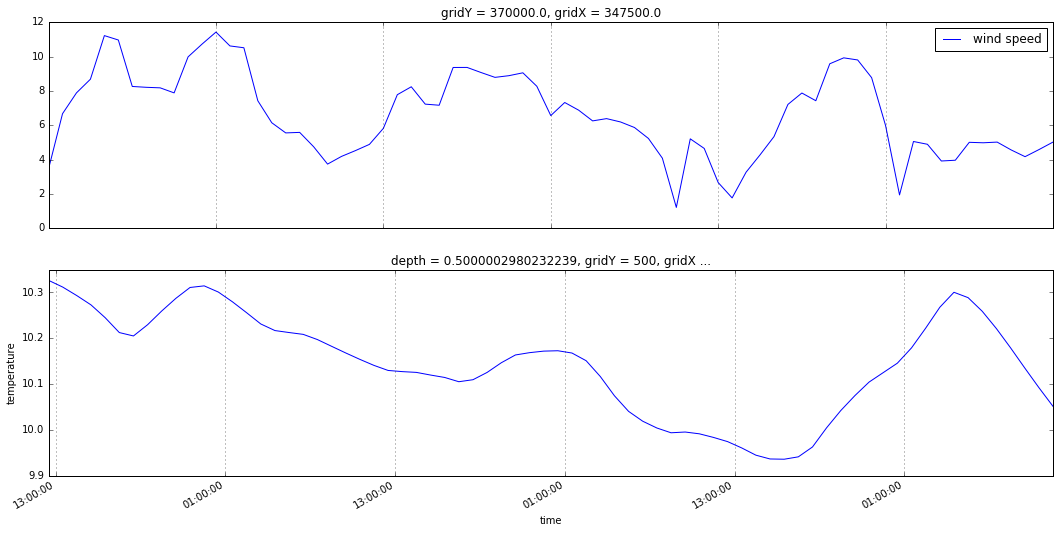

In [18]:
fig, (ax_wind, ax_sst) = plt.subplots(nrows=2, figsize=(18, 9))
wind_speed_dir.speed.plot(ax=ax_wind, label='wind speed')
ax_wind.legend()
ax_wind.grid(axis='x')
sst_ts.plot(ax=ax_sst, label='sst')
ax_sst.grid(axis='x')